<a href="https://colab.research.google.com/github/adap7/IRTM/blob/main/Copy_of_02_4_IRTM_Tutorial_reranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by copying this into your Google Drive!!

# Information Retrieval & Text Mining 2023
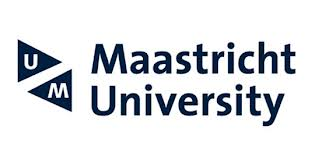
## Tutorial 2 - Notebook 4

In this notebook, we will finetune and evaluate BERT for re-ranking on [MS MACRO](https://huggingface.co/datasets/ms_marco) dataset. We will be using HuggingFace to finetune the model, which makes it easy to plug in any pretrained model on HF Hub that can be used for sequence classification. The model will be finetuned to output a score between 0 and 1 when given a pair of query and passage. You can check the [original paper](https://arxiv.org/abs/1901.04085) for more details.

In [ ]:
!pip install -q transformers datasets
!pip install accelerate -U

In [ ]:
from datasets import Dataset, load_dataset
import torch.nn as nn
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import pandas as pd

We start by loading the dataset.

In [ ]:
dataset = load_dataset('ms_marco', 'v1.1')
dataset

We convert the each set to a Pandas DataFrame to make it easier to handle the data.

In [ ]:
original_train_df = dataset['train'].to_pandas()
original_validation_df = dataset['validation'].to_pandas()
original_test_df = dataset['test'].to_pandas()

len(original_train_df), len(original_validation_df), len(original_test_df)

In [ ]:
original_validation_df.head()

We sample 10% of each set because training on the whole dataset will take a lot of time.

In [ ]:
train_df = original_train_df.sample(frac=0.1).reset_index(drop=True)
validation_df = original_validation_df.sample(frac=0.1).reset_index(drop=True)
test_df = original_test_df.sample(frac=0.1).reset_index(drop=True)

len(train_df), len(validation_df), len(test_df)

If you check passages column, you can see it contains a dictionary with keys and values. We will split that dictionary into multiple columns with keys as the column names.

In [ ]:
train_df = pd.concat([train_df, pd.json_normalize(train_df['passages'])], axis=1)
validation_df = pd.concat([validation_df, pd.json_normalize(validation_df['passages'])], axis=1)
test_df = pd.concat([test_df, pd.json_normalize(test_df['passages'])], axis=1)

validation_df.head()

We want our model to take 1 query and 1 `passage_text` and predict the label `is_selected`. We get closer to the format expected by the model by running explode on `is_selected` and `passage_text` columns to get 1 item per row.

In [ ]:
train_df = train_df.explode(['is_selected', 'passage_text', 'url'])
validation_df = validation_df.explode(['is_selected', 'passage_text', 'url'])
test_df = test_df.explode(['is_selected', 'passage_text', 'url'])

validation_df.head()

In [ ]:
len(train_df), len(validation_df), len(test_df)

Below we use [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) as it is smaller and faster. The model is expected to take a query and a passage and predict a probability of the passage being relevant. by passing 1 to `num_labels`, HuggingFace will add a linear layer with 1 single output, and that is what we need to get our probability.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

After passing a list of queries and passages to the tokenizer, it will automatically concatenate them and put a \[SEP] token in between.

In [ ]:
out = tokenizer(["query"], ["passage"])
decoded_out = tokenizer.decode(out['input_ids'][0])

print(f"Model input: {out}")
print(f"Model input decoded: {decoded_out}")

The model takes a tokenized pair and output one logit.

In [ ]:
model(**tokenizer(["query"], ["document"], return_tensors='pt'))

In [ ]:
train_df = train_df.rename(columns={'is_selected': 'labels'})
validation_df = validation_df.rename(columns={'is_selected': 'labels'})
test_df = test_df.rename(columns={'is_selected': 'labels'})

In [ ]:
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
validation_dataset = Dataset.from_pandas(validation_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

validation_dataset

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["query"], examples["passage_text"], truncation=True, padding=True)

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

tokenized_validation_dataset

We need to customize the trainer to compute binary cross entropy loss. We turn logits into probabilities by applying sigmoid function, then we compute our loss.

### Exercise #1
Update the code below to use [nn.BCEWithLogitsLoss()](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) instead of nn.BCELoss.

In [ ]:
class BCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(torch.float32)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.BCELoss()
        sigmoid = nn.Sigmoid()
        probs = sigmoid(logits)
        loss = loss_fct(probs.view(-1), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Updated code ex 1:
class BCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(torch.float32)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

We clone the [original paper implementation repository](https://github.com/nyu-dl/dl4marco-bert) to be able to use the metrics they defined.

In [ ]:
import sys

!test -d bert_repo || git clone https://github.com/maryszmary/dl4marco-bert dl4marco-bert
if not 'dl4marco-bert' in sys.path:
  sys.path += ['dl4marco-bert']

We format labels and scores as expected by metrics. We need to pass a set of ground truth document ids (in this case it's indices where label is larger than 1) and ordered document ids from most relevant to least that we order based on the scores.

In [ ]:
import numpy as np
import metrics

METRICS_MAP = ['MAP', 'RPrec', 'NDCG', 'MRR', 'MRR@10']

labels = np.array([1, 0, 0])
scores = np.array([0.1, 0.8, 0.3])

gt = set(list(np.where(labels > 0)[0]))
pred_docs = scores.argsort()[::-1]

results = metrics.metrics(gt=gt, pred=pred_docs, metrics_map=METRICS_MAP)

print(f"Ground Truth: {gt}")
print(f"Predicted docs: {pred_docs}")
print(f"Results: {results}")

To compute metrics, we need a list of labels and predictions for each query instead of the exploded version that we prepared before to train the model. That is why we group by `query_ids`.

In [ ]:
def prepare_compute_metrics(query_ids):
  def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.squeeze()
    df = pd.DataFrame.from_dict({'labels': labels, 'preds': preds, 'query_ids': query_ids})
    df = df.groupby('query_ids').agg(list)

    df['labels'] = df['labels'].map(lambda x: set(list(np.where(np.array(x) > 0)[0])))
    df['preds'] = df['preds'].map(lambda x: np.array(x).argsort()[::-1])

    all_metrics = np.zeros(len(METRICS_MAP))
    for _, row in df.iterrows():
      all_metrics+=metrics.metrics(row['labels'], row['preds'], metrics_map=METRICS_MAP)

    all_metrics/=len(df)

    return {
        metric: result for metric, result in zip(METRICS_MAP, all_metrics)
    }

  return compute_metrics

query_ids = tokenized_validation_dataset['query_id']
compute_metrics = prepare_compute_metrics(query_ids)

In [ ]:
training_args = TrainingArguments(
    output_dir="bert_reranker",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2
)

In [ ]:
trainer = BCELossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

### Exercise #2
Write code to get metric results of the model on the test set.

In [ ]:
# Prepare the metrics function for the test set using query_ids from the tokenized test dataset.
test_query_ids = tokenized_test_dataset['query_id']
compute_metrics_test = prepare_compute_metrics(test_query_ids)

# Instantiate a trainer for evaluation on the test dataset.
# (You can reuse training arguments; these will be used for evaluation as well.)
test_trainer = BCELossTrainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_test
)

# Run evaluation on the test set and collect the results.
test_results = test_trainer.evaluate()

# Print the computed metric results for the test set.
print("Test Set Metric Results:")
print(test_results)

###Exercise #3
Save the model, then load it back and use it to predict scores for the lists of queries and passages below.

In [ ]:
queries = original_validation_df.loc[0:5, 'query'].tolist()
passages = original_validation_df.loc[0:5, 'passages'].tolist()



In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# ---------------------------
# Step 1: Save the model and tokenizer
# ---------------------------
# Save the current model and tokenizer after training
save_directory = "saved_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to '{save_directory}'.")

# ---------------------------
# Step 2: Load the model and tokenizer back
# ---------------------------
loaded_model = AutoModelForSequenceClassification.from_pretrained(save_directory)
loaded_tokenizer = AutoTokenizer.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully.")

# ---------------------------
# Step 3: Define lists of queries and passages for prediction
# ---------------------------
# Replace these sample entries with your own queries and passages as needed
queries = [
    "Where can I watch football?",
    "What are the latest developments in science?",
    "How do I fix my car?"
]

passages = [
    "Football games are broadcasted on many channels across the country.",
    "Recent scientific breakthroughs have been announced in the field of renewable energy.",
    "Fixing a car may involve replacing worn-out parts or performing a simple tune-up."
]

# ---------------------------
# Step 4: Tokenize the input pairs
# ---------------------------
inputs = loaded_tokenizer(
    queries,
    passages,
    return_tensors="pt",  # Return PyTorch tensors
    truncation=True,
    padding=True
)

# ---------------------------
# Step 5: Generate predictions
# ---------------------------
# Disable gradient calculation for inference
with torch.no_grad():
    outputs = loaded_model(**inputs)
    # For models with num_labels=1, logits is expected to have shape [batch_size, 1]
    # We'll squeeze it into a 1D tensor for easier interpretation.
    scores = outputs.logits.squeeze(dim=-1)

# ---------------------------
# Step 6: Display the predicted scores
# ---------------------------
print("Predicted scores:")
for query, score in zip(queries, scores.tolist()):
    print(f"Query: '{query}'  Score: {score:.4f}")